# Notebook to Explore Samples of NEON Hyperspectral Image Data

Written by Chris Stewart - 2021/02/10

The purpose of this notebook is to explore a subset of NEON hyperspectral imaging, perform some basic data loading/processing, exploratory data analysis, and some resampling and visualization

NEON Citation:
National Ecological Observatory Network. 2021. Data Product DP3.30006.001, Spectrometer orthorectified surface directional reflectance - mosaic. Provisional data downloaded from http://data.neonscience.org on February 11, 2021. Battelle, Boulder, CO, USA NEON. 2021.

## NB OVERVIEW & TO DO:

### 1. Data loading code:
- Code that takes in a filepath and walks the folders and files and returns filenames and paths of all h5 files - DONE
- Function that takes in the filename and path of a hdf5 (.h5) file and reads the hdf5 structure and available datasets, prints group names, dataset names and attributes - DONE
- Function that takes in a filename and path loads in the reflectance data and a dictionary of the metadata - DONE

### 2. EDA:

- check dimensions of arrays and size in memory - DONE
- min/maxes of values - DONE
- Check band centres and see if they are consistant (i.e. evenly distributed accross spectrum) - DONE
- Check FWHM distances and see if they are consistant - DONE
- plot spectral graph, for single and multiple spectra - DONE
- plot histograms of distributions of values for reflectance and wavelength

optional: tool that shows image and lets you click on pixel and shows you the spectral graph on that pixel or range of pixels

### Visualize the image:
need function/code that can translate between spectral and reflectance data and RGB or other values for easy plotting/visualization with PIL - DONE

### Spatial resampling:
write function that takes in array of data and downscales based on desired GSD scale parameter "Average method" - DONE (Needs image resize)



### Change log for week of 29/03/2021:
- Fixed skimage bug
- Implemented 

### Change log for week of 29/03/2021:
- Colab and data store set up on Google drive

### Change log for week of 15/03/2021:
- Set up Colab - Partially Complete - question around do we want to: A) Maintain slightly different versions for local vs. colab notebooks/scripts or adapt the current notebook to use pydrive and all data lives in google drive?
- Upload sample hdf5 and generated image data to drive - Done
- Technical Note - Done (may add a couple more things)
- Cleanup - Done (this round)

### Change log for week of 08/03/2021:
- added functionality to write out a resampled data cube to a new hdf5 file
- generated more sample images
- added technical note about downsampling - will add to this more

- Looked into colab and it looks like a good option - 12 GB RAM and ~40 GB Disk (depends on runtime instance), free GPUs!
- Basically its a Juptyer notebooks google doc - very shareable/collaborative, can load/write data easily from google drive as well



- __TODO:__ Its possible to install additional packages/libraries into Colab, need to figure out an easy way to load all required ones __not__ manually

- Revise image generation Think about/explore good ways to communicate hyperspectal images (specifically the changes that occur between original and resmapled)



### Change log for week of 01/03/2021:
- fix spectral plots to be more clear with band centres and band edges indicated
- combined algorithm that does spatial and spectral downsampling
- started working on a self-contained executable script

### Change log for week of 22/02/2021:
- incorporated clamp [0,1] method into h5data2array so that it truely outputs a "clean" reflectance array
- also added optional parameter to h5data2array which lets you toggle clamping functionality on/off to either work with clean data or explore why there are reflectance values > 1
- Linear interpolation spectral resampling method: take in 2 arrays of new band centres and FWHMs 
- general cleanup

In [1]:
# libraries

# data
import pandas as pd
# import geopandas as geopd # for working with geolocation data
import numpy as np
import h5py
from PIL import Image

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import cartopy.crs as ccrs # for working with geolocation data
# import cartopy.feature as cfeature

# ml
import sklearn as skl
import skimage.measure
import skimage.transform

# utilites
import sys
import os 
from pathlib import Path
import datetime as dt
from tqdm.notebook import tqdm, trange # progress bars
tqdm.pandas()
import timeit

# dataframe options
pd.set_option('display.max_columns', None)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Data loading functions:

1. find_files - code that takes in a filepath and walks the folders and files and returns filenames and paths of all h5 files
2. hdf5 file dump - useful exploratory code to map the structure of NEON's hdf5 files and metadata
3. h5data2array - function that loads the given h5 file and returns the relevant datasets: refl_clean, wavelength_array, FWHM_array, metadata

### Data loading #1: find_files function

This will locate all hdf5 files within a given data directory and return a dictionary of filenames and paths.

In [2]:
def find_files(data_dir_path):
    """
    This function takes in a path to a data directory, walks the directory and 
    returns a dictionary of the filenames and paths of all the data files.
    """
    
    # get all the h5 data filenames and paths
    file_dict = {} # to store file:path pairs
    print('Finding data files...')
    for p, _, file in os.walk(data_dir_path): # get all the data files and their paths
        for f in file:
            if f.endswith(".h5"): # only .h5 files read in
                file_dict[f] = os.path.join(p, f) # if you want a string path
                #file_dict[f] = Path(os.path.join(p, f)) # if you want a Path object path

    return file_dict

### Test out the find_files function:

In [3]:
data_dir_path = Path(os.getcwd()).parents[0] / 'data' / 'NEON' # get path to data files

file_dict = find_files(data_dir_path)
file_dict

Finding data files...


{'NEON_D10_RMNP_DP3_459000_4448000_2017_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D10.RMNP.DP3.30006.001.2017-07.basic.20210401T092346Z.RELEASE-2021\\NEON_D10_RMNP_DP3_459000_4448000_2017_reflectance.h5',
 'NEON_D10_RMNP_DP3_459000_4448000_2018_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D10.RMNP.DP3.30006.001.2018-09.basic.20210401T092346Z.RELEASE-2021\\NEON_D10_RMNP_DP3_459000_4448000_2018_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-p

### Data loading #2: h5dump function

This will give us the structure of the NEON hdf5 file and its available datasets within.

In [4]:
# HDF5 file structure map from this SO answer: https://stackoverflow.com/a/53340677
# Much more better!
def descend_obj(obj,sep='\t'):
    """
    Iterate through groups in a HDF5 file and prints the groups and datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group,h5py._hl.files.File]:
        for key in obj.keys():
            print(sep,'-',key,':',obj[key])
            descend_obj(obj[key],sep=sep+'\t')
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print(sep+'\t','-',key,':',obj.attrs[key])

def h5dump(path,group='/'):
    """
    print HDF5 file metadata

    group: you can give a specific group, defaults to the root group
    """
    with h5py.File(path,'r') as f:
         descend_obj(f[group])

### Test out the h5dump function:

This will give us the structure of the NEON hdf5 file and its available datasets within - of particular interest to us here are three datasets:
- Wavelength
- Full Width Half Maximum (FWHM)
- Reflectance

In [5]:
h5dump(file_dict["NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5"])

	 - ABBY : <HDF5 group "/ABBY" (1 members)>
		 - Reflectance : <HDF5 group "/ABBY/Reflectance" (2 members)>
			 - Metadata : <HDF5 group "/ABBY/Reflectance/Metadata" (7 members)>
				 - Ancillary_Imagery : <HDF5 group "/ABBY/Reflectance/Metadata/Ancillary_Imagery" (14 members)>
					 - Aerosol_Optical_Depth : <HDF5 dataset "Aerosol_Optical_Depth": shape (1000, 1000), type "<i2">
							 - Band_Names : b'AOT (aerosol optical thickness at 550 nm)*1000'
							 - Data_Ignore_Value : -9999.0
							 - Description : b'Aerosol Optical Depth at 500 nm.'
							 - Scale_Factor : 1000.0
							 - Units : b'Aerosol Optical Depth at 500 nm.'
					 - Aspect : <HDF5 dataset "Aspect": shape (1000, 1000), type "<f4">
							 - Data_Ignore_Value : -9999.0
							 - Description : b'Aspect used as input to ATCOR'
							 - Dimension_Labels : b'-'
							 - Scale_Factor : 1.0
							 - Units : b'degrees'
					 - Cast_Shadow : <HDF5 dataset "Cast_Shadow": shape (1000, 1000), type "|u1">
							 - Data_Ign

### Data Loading: h5data2array function 

This loads the given h5 file and returns the relevant datasets:
- refl_clean: cleaned and scaled reflectance data
- wavelength_array: array of band wavelength centre
- FWHM_array: Full Width Half Maximum of bands
- metadata: includes some useful auxiliary information

Based on example code from NEON code examples:

https://www.neonscience.org/resources/learning-hub/tutorials/hdf5-intro-python

https://www.neonscience.org/resources/learning-hub/tutorials/calc-ndvi-tiles-py

In [6]:
def h5data2array(data_file_path, clamp_values=True):
    """
    h5dataset2array reads in a hdf5 file and extracts and returns:  
        1. reflectance array (with the no data value and reflectance scale factor applied)
        2. dictionary of metadata including spatial information, and wavelengths of the bands
    --------
    Parameters
        data_file_path -- full or relative path and name of reflectance hdf5 file
    --------
    Returns
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'nm' (string)
    --------
    Example Execution:
    --------
    refl_clean, wavelength_array, FWHM_array, metadata = h5data2array("NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5")
    
    """
    
    hdf5_file = h5py.File(data_file_path,'r') # open file
    #Get the site name
    file_attrs_str = str(list(hdf5_file.items())).split("'")
    sitename = file_attrs_str[1]

    # Extract the reflectance & wavelength datasets
    refl_obj = hdf5_file[sitename]['Reflectance']
    refl_data = refl_obj['Reflectance_Data'] # reflectance dataset

    # Create dictionary containing relevant metadata information
    metadata_dict = {}
    metadata_dict['map info'] = refl_obj['Metadata']['Coordinate_System']['Map_Info']
    metadata_dict['wavelength'] = refl_obj['Metadata']['Spectral_Data']['Wavelength']

    # Extract no data value & scale factor
    metadata_dict['data ignore value'] = float(refl_data.attrs['Data_Ignore_Value'])
    metadata_dict['reflectance scale factor'] = float(refl_data.attrs['Scale_Factor'])
    metadata_dict['Spatial_Resolution_X_Y'] = refl_data.attrs['Spatial_Resolution_X_Y']

    # Apply no data value
    refl_array = np.array(refl_data)
    arr_size = refl_data.shape
    if np.isin(refl_array, metadata_dict['data ignore value']).any():
        print('% No Data: ',np.round(np.count_nonzero(refl_array == metadata_dict['data ignore value'])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1)) # calculates % of missing data values
        refl_array[np.where(refl_array == metadata_dict['data ignore value'])] = 0.0 # use float instead #np.nan # replace no data values with NaNs

    # Apply scale factor
    refl_array = refl_array/metadata_dict['reflectance scale factor']

    # metadata
    # extract wavelength bands and FWHMs
    wavelength_array = refl_obj['Metadata']['Spectral_Data']['Wavelength'][...] # wavelength dataset
    FWHM_array = refl_obj['Metadata']['Spectral_Data']['FWHM'][...] # FWHM dataset
    
    # Extract spatial extent from attributes
    metadata_dict['spatial extent'] = refl_data.attrs['Spatial_Extent_meters']

    # Extract projection information
    metadata_dict['projection'] = refl_obj['Metadata']['Coordinate_System']['Proj4'][...]
    metadata_dict['epsg'] = int(refl_obj['Metadata']['Coordinate_System']['EPSG Code'][...])

    # Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl_obj['Metadata']['Coordinate_System']['Map_Info'][...]

    hdf5_file.close # close file
    
    # clamping function for values outside the acceptable range
    def clamp(array, low, high):
        array[array < low] = low
        array[array > high] = high
        return array
    
    if clamp_values:
        refl_clean = clamp(refl_array, 0, 1) # first clamp to [0,1] range
        return refl_clean, wavelength_array, FWHM_array, metadata_dict
    else:
        return refl_array, wavelength_array, FWHM_array, metadata_dict

### Test out the h5data2array function:

This will load in the three key datasets:
- Wavelength
- Full Width Half Maximum (FWHM)
- Reflectance

In [7]:
file_dict

{'NEON_D10_RMNP_DP3_459000_4448000_2017_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D10.RMNP.DP3.30006.001.2017-07.basic.20210401T092346Z.RELEASE-2021\\NEON_D10_RMNP_DP3_459000_4448000_2017_reflectance.h5',
 'NEON_D10_RMNP_DP3_459000_4448000_2018_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D10.RMNP.DP3.30006.001.2018-09.basic.20210401T092346Z.RELEASE-2021\\NEON_D10_RMNP_DP3_459000_4448000_2018_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-p

In [8]:
# test the h5data2array
data_file_path = file_dict['NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5']
refl_array, wavelength_array, FWHM_array, metadata_dict = h5data2array(data_file_path, clamp_values=False) # don't clamp values to explore their true range
refl_array

array([[[0.0092, 0.0187, 0.0168, ..., 0.0184, 0.025 , 0.0483],
        [0.0108, 0.0179, 0.0136, ..., 0.0089, 0.0307, 0.0218],
        [0.0103, 0.0161, 0.016 , ..., 0.0216, 0.0352, 0.048 ],
        ...,
        [0.0115, 0.0211, 0.0224, ..., 0.0071, 0.0316, 0.088 ],
        [0.012 , 0.0229, 0.0215, ..., 0.0089, 0.0312, 0.0905],
        [0.0102, 0.0239, 0.0195, ..., 0.0425, 0.0499, 0.1174]],

       [[0.0126, 0.0198, 0.0178, ..., 0.0121, 0.0189, 0.0293],
        [0.0129, 0.0224, 0.0209, ..., 0.0333, 0.0183, 0.0628],
        [0.0141, 0.0176, 0.0191, ..., 0.0164, 0.0042, 0.0336],
        ...,
        [0.0158, 0.0272, 0.0239, ..., 0.0175, 0.0738, 0.0626],
        [0.0114, 0.0248, 0.0231, ..., 0.0324, 0.0851, 0.1389],
        [0.0132, 0.018 , 0.014 , ..., 0.0076, 0.0806, 0.093 ]],

       [[0.0122, 0.0209, 0.0247, ..., 0.0182, 0.0415, 0.0608],
        [0.0178, 0.0227, 0.0226, ..., 0.0253, 0.0282, 0.0371],
        [0.0125, 0.0175, 0.0242, ..., 0.0123, 0.0478, 0.0484],
        ...,
        [0.0

## 2. Exploratory Data Analysis:

After loading data let's perform some sanity checks and dig into values to better understand hyperspectral data.
- First let's check the dimensions of our data arrays and size in memory:

In [9]:
print("Reflectance dataset info:")
print("dtype: " + str(refl_array.dtype))
print("Array Shape: " + str(refl_array.shape))
print("Size in memory (Mbytes): " + str(refl_array.nbytes/1000000)) # size of array in memory
print("-"*35)

print("Wavelength dataset info:")
print("dtype: " + str(wavelength_array.dtype))
print("Array Shape: " + str(wavelength_array.shape))
print("Size in memory (Kbytes): " + str(wavelength_array.nbytes/1000)) # size of array in memory
print("-"*35)

print("FWHM dataset info:")
print("dtype: " + str(FWHM_array.dtype))
print("Array Shape: " + str(FWHM_array.shape))
print("Size in memory (Kbytes): " + str(FWHM_array.nbytes/1000)) # size of array in memory
print("-"*35)

Reflectance dataset info:
dtype: float64
Array Shape: (1000, 1000, 426)
Size in memory (Mbytes): 3408.0
-----------------------------------
Wavelength dataset info:
dtype: float32
Array Shape: (426,)
Size in memory (Kbytes): 1.704
-----------------------------------
FWHM dataset info:
dtype: float32
Array Shape: (426,)
Size in memory (Kbytes): 1.704
-----------------------------------


- Check some overview stats and min/maxes of values:

In [10]:
print("Mean reflectance: "'{number:.{digits}f}'.format(number=refl_array[:,:,:].mean(), digits=3))
print("Std Dev.: "'{number:.{digits}f}'.format(number=refl_array[:,:,:].std(), digits=3))
print("Min reflectance: "'{number:.{digits}f}'.format(number=refl_array[:,:,:].min(), digits=3))
print("Max reflectance: "'{number:.{digits}f}'.format(number=refl_array[:,:,:].max(), digits=3))
print("-"*35)
print("Mean wavelength: "'{number:.{digits}f}'.format(number=wavelength_array.mean(), digits=3))
print("Std Dev.: "'{number:.{digits}f}'.format(number=wavelength_array.std(), digits=3))
print("Min wavelength: "'{number:.{digits}f}'.format(number=wavelength_array.min(), digits=3))
print("Max wavelength: "'{number:.{digits}f}'.format(number=wavelength_array.max(), digits=3))
print("-"*35)
print("Mean FWHM: "'{number:.{digits}f}'.format(number=FWHM_array.mean(), digits=3))
print("Std Dev.: "'{number:.{digits}f}'.format(number=FWHM_array.std(), digits=3))
print("Min FWHM: "'{number:.{digits}f}'.format(number=FWHM_array.min(), digits=3))
print("Max FWHM: "'{number:.{digits}f}'.format(number=FWHM_array.max(), digits=3))
print("-"*35)

Mean reflectance: 0.125
Std Dev.: 0.183
Min reflectance: 0.000
Max reflectance: 1.565
-----------------------------------
Mean wavelength: 1446.173
Std Dev.: 616.077
Min wavelength: 381.598
Max wavelength: 2510.749
-----------------------------------
Mean FWHM: 5.748
Std Dev.: 0.236
Min FWHM: 5.536
Max FWHM: 6.346
-----------------------------------


- Check for any missing data values:

In [11]:
#np.count_nonzero(np.isnan(refl_array)) # this takes a long time to run, don't run it regularly

Interestingly we can see that even after scaling we get a maximum reflectance value of 1.565 -> is this an outlier/artifact or maybe due to object radiating its own EM emissions?

- Lets visualize what some reflectance signals looks like with some spectral graphs for multiple image pixels

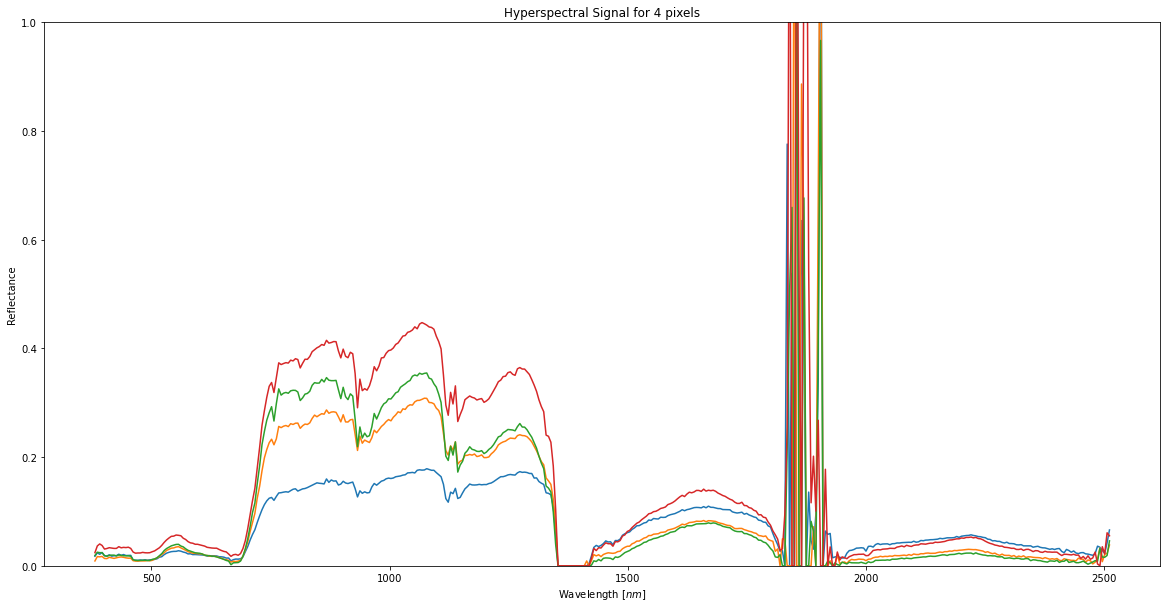

In [12]:
i, j = 0, 0
fig, ax = plt.subplots(figsize=(20, 10))
# plot some random wavelengths
ax.plot(wavelength_array, refl_array[i+50,j,:])
ax.plot(wavelength_array, refl_array[i,j+50,:])
ax.plot(wavelength_array, refl_array[i+800,j+800,:])
ax.plot(wavelength_array, refl_array[i+900,j+900,:])
#ax.set_xticks(range(0, 250, 3000))
plt.title("Hyperspectral Signal for 4 pixels")
plt.ylabel('Reflectance')
plt.ylim((0,1))
plt.xlabel('Wavelength [$nm$]')
plt.show()

We should also check the hyperspectral wavelength and FWHM metadata

- Check band centres and see if they are consistant (i.e. evenly distributed accross spectrum)
- Check FWHM distances and see if they are consistant

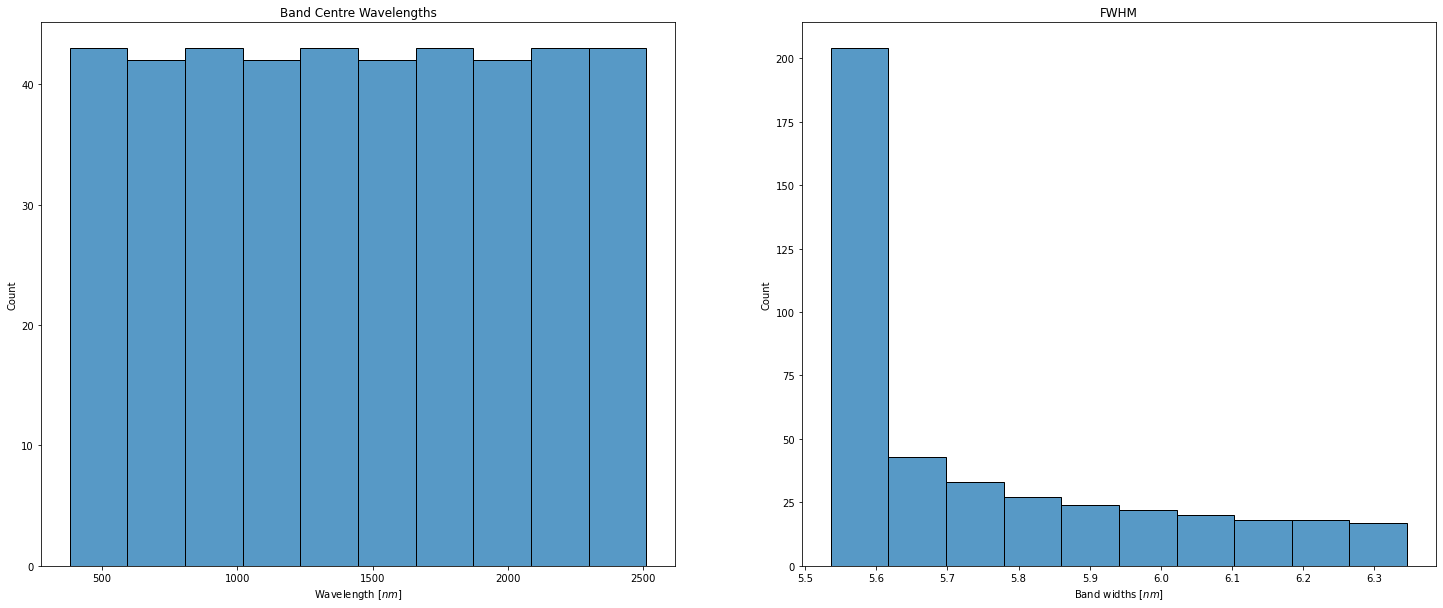

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
sns.histplot(data=wavelength_array, ax=ax[0])
sns.histplot(data=FWHM_array, ax=ax[1])

ax[0].set_xlabel("Wavelength [$nm$]")
ax[0].set_title("Band Centre Wavelengths")
ax[1].set_xlabel("Band widths [$nm$]")
ax[1].set_title("FWHM")


plt.show()

We can see the wavelengths are pretty evenly distributed and the FWHM are primarily < 5.6 nm with some slightly wider bands as well

Lets plot some lines to visualize the band centres:

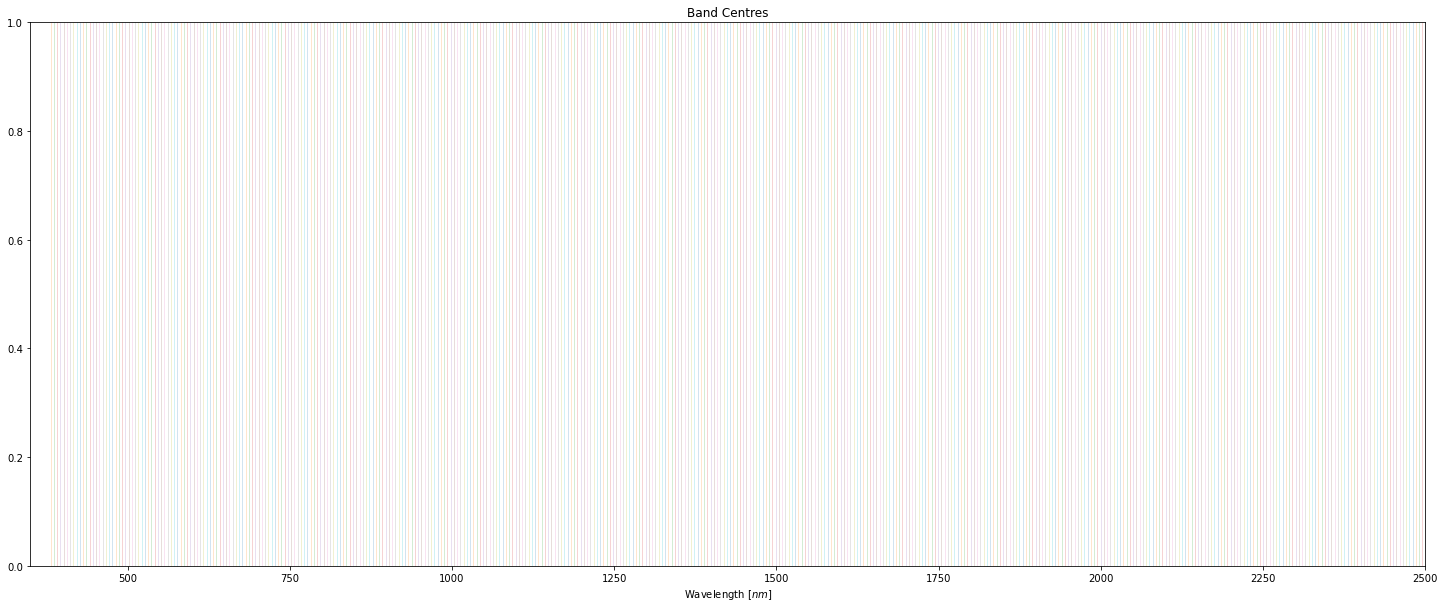

In [14]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.lineplot(data=wavelength_array, ax=ax)
#sns.histplot(data=FWHM_array, ax=ax[1])

ax.set_xlabel("Wavelength [$nm$]")
ax.set_title("Band Centre Wavelengths")

plt.title("Band Centres")
#plt.ylabel('Reflectance')
plt.ylim((0,1))
plt.xlim((350,2500))
plt.xlabel('Wavelength [$nm$]')

for w in wavelength_array:
    sns.lineplot(x=[w,w], y=[0,1], ax=ax)

plt.show()

### After exploring the data a bit we can call our h5data2array function leaving the default clamping value as true to create a "clean" reflectance array

In [15]:
# reload the h5data2array for a "clean" array
data_file_path = file_dict['NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5']
refl_array, wavelength_array, FWHM_array, metadata_dict = h5data2array(data_file_path)

## 3. Visualize Image

Quick function to pull out a few of the visible light bands and visualize the image

In [16]:
def toRGB(refl_array, filename_output, mode=1):
    """
    This is a rough way to convert visualize parts of a hyperspectrum and show them in RGB colour images
    This tool was helpful: https://academo.org/demos/wavelength-to-colour-relationship/
    and this resource: https://towardsdatascience.com/image-processing-with-python-5b35320a4f3c
    -----------------------------------------------------------------------------------------------------
    red ~= 625–740 nm -> pick 700 nm -> rgb(255,0,0) : wavelength_array[64] = 702.223
    green ~= 495–570 nm -> pick 510 nm -> rgb(0,255,0) : wavelength_array[26] = 511.8519
    blue ~= 450-495 nm -> pick 440 nm - > rgb(0,0,255) : wavelength_array[12] = 441.7151
    
    mode 2: new bands
    # 0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646,  0.665, 0.682, 0.699, 0.715, 0.730, 0.745, 0.762, 0.779, 0.787, 0.804
    red ~= 625–740 nm -> pick 700 nm -> rgb(255,0,0) : wavelength_array[10] = 699
    green ~= 495–570 nm -> pick 510 nm -> rgb(0,255,0) : wavelength_array[0] = 505, pick 544 wavelength_array[4] instead
    blue ~= 450-495 nm -> pick 440 nm - > rgb(0,0,255) : wavelength_array[0] = 505 pick  wavelength_array[1]
    """
    if (mode == 1):
        # this mode is for original 426 spectrum array
        red = refl_array[:,:,64] + refl_array[:,:,64-1] + refl_array[:,:,64+1]
        green = refl_array[:,:,26] + refl_array[:,:,26-1] + refl_array[:,:,26+1]
        blue = refl_array[:,:,12] + refl_array[:,:,12-1] + refl_array[:,:,12+1]
        
    else:
        # this mode is for downsampled 18 spectrum array
        red = refl_array[:,:,10] + refl_array[:,:,10-1] + refl_array[:,:,10+1]
        green = refl_array[:,:,4] + refl_array[:,:,4-1] + refl_array[:,:,4+1]
        blue = refl_array[:,:,1] + refl_array[:,:,1-1] + refl_array[:,:,1+1]
        
        
    
    # clamping function for values outside the acceptable range
    def clamp(array, low, high):
        array[array < low] = low
        array[array > high] = high
        return array
    
    red_clampd = clamp(red, 0.0, 1.0)
    green_clampd = clamp(green, 0.0, 1.0)
    blue_clampd = clamp(blue, 0.0, 1.0)

    colour_array = np.stack((red_clampd, green_clampd, blue_clampd), axis=-1)
     
    im = Image.fromarray(np.uint8(colour_array*255))

    plt.imshow(np.asarray(im))
    plt.show()

    im.save(filename_output) # save file to .png
    #im.show()

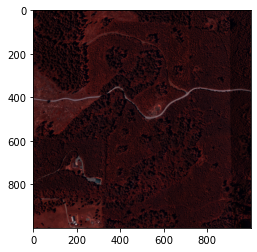

In [11]:
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'interim' / 'img' / 'original_img_1m.png' # output path to save processed data files
toRGB(refl_array, output_data_path) # generate image

## 3. Spatial Resampling
A function that takes in array of data and downscales based on desired GSD scale parameter
"Average method"

In [17]:
def downSample_spatial_array(img_array, GSD_input, GSD_output):
    """
    Takes in a img array, input GSD and desired output GSD and downsamples the array by
    a calculated downsampling factor (the ratio between the output and input GSD parameters)
    --------
    Example Execution:
    --------
    img_array_ds = downSample_array(img_array, 1, 2) # downsample image by factor of 2
    
    """
    downsample_factor = max(int(round(GSD_output/GSD_input)),1) # calculate the downsampling factor - only integers!
    rescale_factor = float(downsample_factor)
    img_array_ds = skimage.measure.block_reduce(img_array[:, :, :], block_size=(downsample_factor, downsample_factor, 1), func=np.mean) # downsample image array
    return skimage.transform.rescale(img_array_ds,(rescale_factor,rescale_factor,1.0)) # scale back up to original size (interpolates)

Now lets try this in action and generate the images:

In [ ]:
# downsample to a 2 m GSD
#ds_img_array_2m = downSample_spatial_array(refl_array, 1, 2) # try a 2 m GSD
# print("Check that output image is the same size as original")
# print("Original Image Size:")
# print(refl_array.shape)
# print("Downsampled Image Size:")
# print(ds_img_array_2m.shape)
# output the 2 m GSD one
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'interim' / 'img' / 'ds_img_2m.png' # output path to save processed image
toRGB(downSample_spatial_array(refl_array, 1, 2), output_data_path)
#del ds_img_array_2m # delete var to free up memory

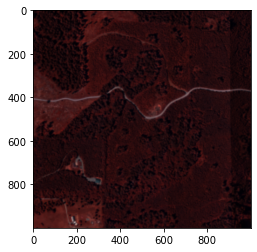

In [22]:
# 4 m GSD
# downsample to a 4 m GSD
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'interim' / 'img' / 'ds_img_4m.png' # output path to save processed image
toRGB(downSample_spatial_array(refl_array, 1, 4), output_data_path)

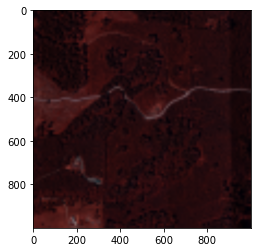

In [23]:
# 10 m GSD
# downsample to a 10 m GSD
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'interim' / 'img' / 'ds_img_10m.png' # output path to save processed image
toRGB(downSample_spatial_array(refl_array, 1, 10), output_data_path)

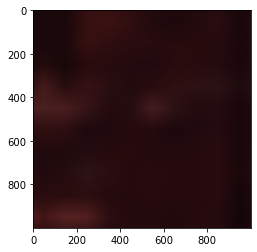

In [24]:
# downsample to a 100 m GSD for fun to see effect
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'interim' / 'img' / 'ds_img_100m.png' # output path to save processed image
toRGB(downSample_spatial_array(refl_array, 1, 100), output_data_path) # output the 100 m GSD one

## 4. Spectral Resampling
We have a function that takes in an array of a reflectance values for a single spectral pixel and its corresponding band centre wavelengths and then it outputs a resampled reflectance spectrum with new desired band centre wavelengths.

Note: The function uses a linear interpolation method in the resampling.

In [ ]:
def reband_spectral_array(spect_array, input_bandcentres_array, output_bandcentres_array):
    """
    Takes in both a 1D spectral array and a input array of band centres and then returns the linearly interpolated
    reflectance values of the desired output bands.
    NOTE: input band centre wavelengths are all in nm units
    
    Parameters
    -----------
    spect_array : 1-D array_like
                Array of image spectral reflectance values that will be used as the basis for rebanding
                
    input_bandcentres_array : 1-D array_like
                Array of the band centre wavelengths for the given spectral reflectance array
                
    output_bandcentres_array : 1-D array_like
                Array of the desired new band centre wavelengths
    --------
    Example Execution:
    --------
    refl_array_new = reband_spec(spect_array, input_bandcentres_array, output_bandcentres_array)
    
    """
    if len(input_bandcentres_array) == len(spect_array): # error checking
        return np.interp(x=output_bandcentres_array, xp=input_bandcentres_array, fp=spect_array, left=None, right=None, period=None)
    else:
        print("Error: input spectral array must be same length as input band centres array")

In [ ]:
# we need to create a new desired set of band centre wavelengths to test our function
# 0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646,  0.665, 0.682, 0.699, 0.715, 0.730, 0.745, 0.762, 0.779, 0.787, 0.804
desired_band_centres = np.array([0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646, 0.665, 0.682, 0.699, 0.715, 0.730, 0.745, 0.762, 0.779, 0.787, 0.804])
desired_band_centres = desired_band_centres*1000
print(desired_band_centres)

In [ ]:
reband_spectral_array(refl_array[0,0,:], wavelength_array, desired_band_centres)

In [22]:
# function to create band widths array
def band_widths(bandcentres_array):
    """
    Generates band widths from given band centre wavelengths
    """
    bandwidths_array = np.empty(len(bandcentres_array)) # create empty array to store bands widths
    
    for i in range(0,len(bandcentres_array)-1): # calculate band width as difference between band centres (approximation)
        bandwidths_array[i] = (bandcentres_array[i+1] - bandcentres_array[i])
    
    # handle last index case
    bandwidths_array[-1] = (bandcentres_array[-1] - bandcentres_array[-2])
    
    return bandwidths_array

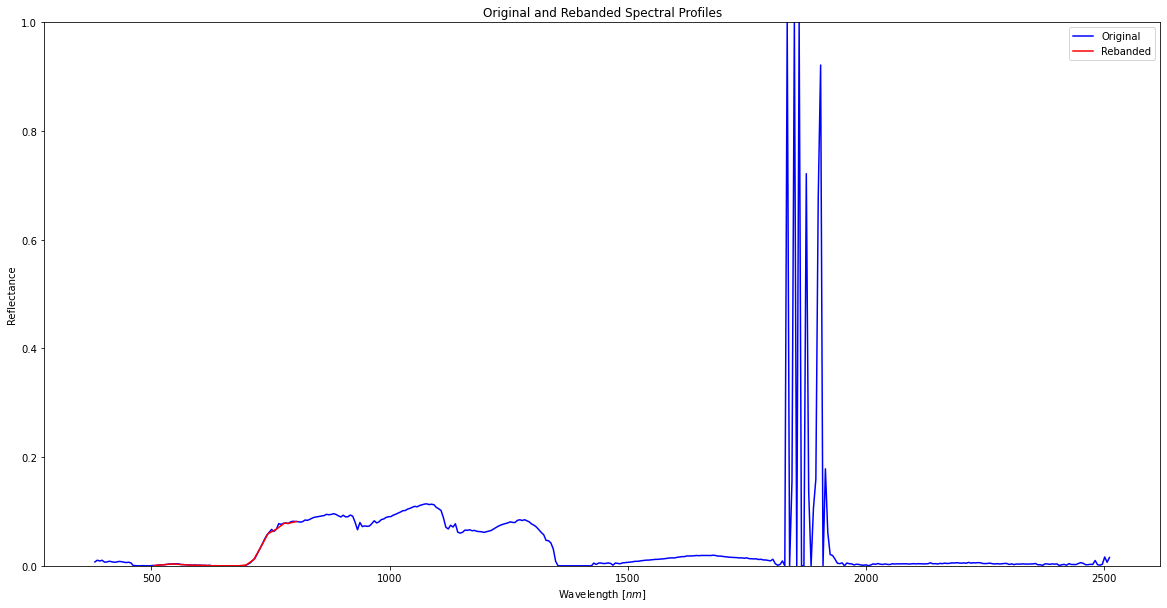

In [32]:
i, j = 100, 100
fig, ax = plt.subplots(figsize=(20, 10))
# plot some random wavelengths
temp_spec = reband_spectral_array(refl_array[i,j,:], wavelength_array, desired_band_centres)

ax.plot(wavelength_array, refl_array[100,100,:], c='b', label="Original")
ax.plot(desired_band_centres, temp_spec, c='r', label="Rebanded")
#ax.plot([desired_band_centres,desired_band_centres], [0,1], c='k', dashes=[2, 2, 10, 2], alpha=0.5, label='Using the dashes parameter') # band centres # 2pt line, 2pt break, 10pt line, 2pt break
#ax.plot([desired_band_centres,desired_band_centres], [0,1], c='k', dashes=[2, 2, 10, 2], alpha=0.5, label='Using the dashes parameter') # band widths
plt.title("Original and Rebanded Spectral Profiles")
plt.ylabel('Reflectance')
plt.ylim((0,1))
plt.xlabel('Wavelength [$nm$]')
plt.legend()
plt.show()

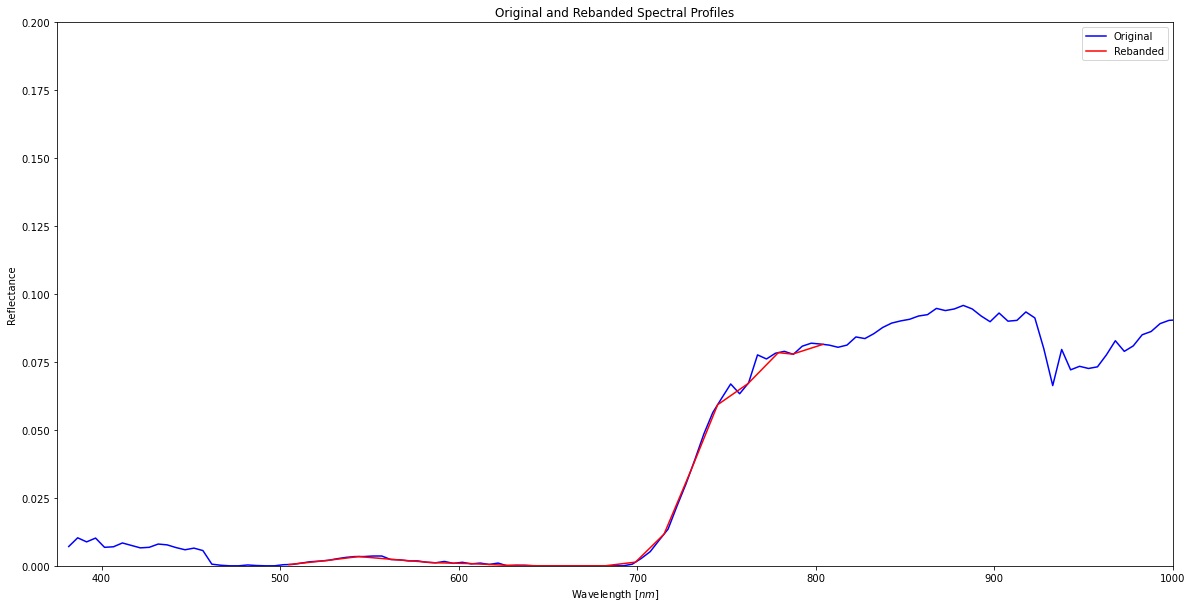

In [31]:
i, j = 100, 100
fig, ax = plt.subplots(figsize=(20, 10))
# plot some random wavelengths
temp_spec = reband_spectral_array(refl_array[i,j,:], wavelength_array, desired_band_centres)

ax.plot(wavelength_array, refl_array[100,100,:], c='b', label="Original")
ax.plot(desired_band_centres, temp_spec, c='r', label="Rebanded")
#ax.plot([desired_band_centres,desired_band_centres], [0,1], c='k', dashes=[2, 2, 10, 2], alpha=0.5, label='Using the dashes parameter') # band centres # 2pt line, 2pt break, 10pt line, 2pt break
#ax.plot([desired_band_centres,desired_band_centres], [0,1], c='k', dashes=[2, 2, 10, 2], alpha=0.5, label='Using the dashes parameter') # band widths
plt.title("Original and Rebanded Spectral Profiles")
plt.ylabel('Reflectance')
plt.ylim((0,0.2))
plt.xlim((375,1000))
plt.xlabel('Wavelength [$nm$]')
plt.legend()
plt.show()

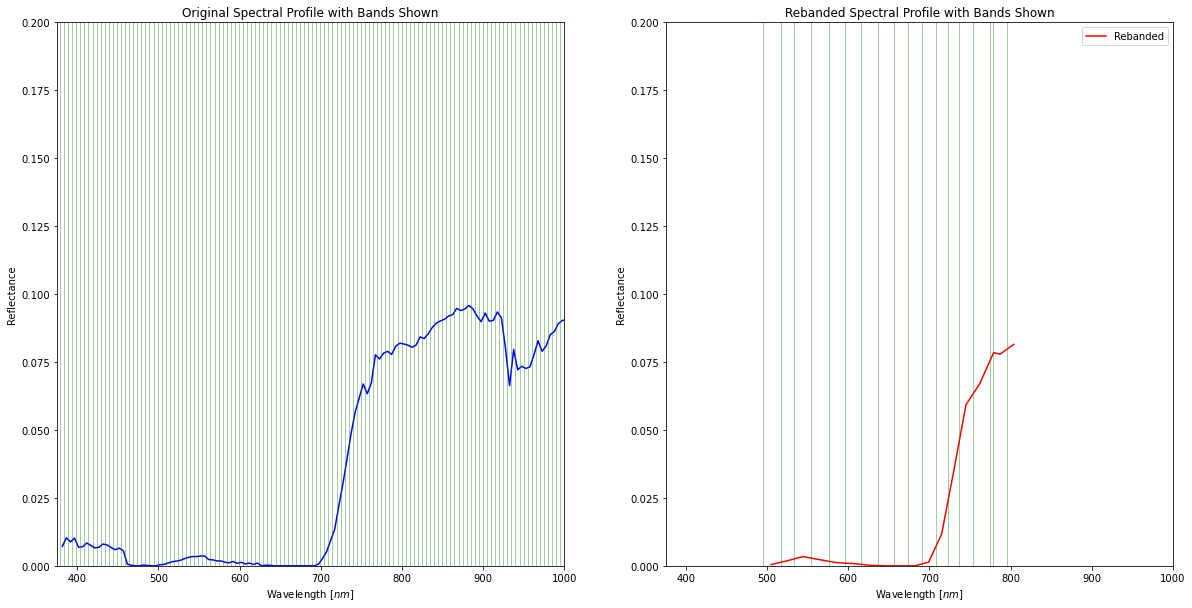

In [32]:
i, j = 100, 100
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
# plot random wavelength (pixel i,j)
temp_spec = reband_spectral_array(refl_array[i,j,:], wavelength_array, desired_band_centres)
temp_bandwidths = band_widths(desired_band_centres)

# original spectrum
ax[0].plot(wavelength_array, refl_array[i,j,:], c='b', label="Original")
ax[0].plot([wavelength_array-FWHM_array/2,wavelength_array-FWHM_array/2], [0,1], c='g', alpha=0.75, linewidth=0.5) # band widths

# rebanded spectrum
#ax[0].plot(wavelength_array, refl_array[i,j,:], c='b', label="Original")
ax[1].plot(desired_band_centres, temp_spec, c='r', label="Rebanded")
ax[1].plot([desired_band_centres-temp_bandwidths/2,desired_band_centres-temp_bandwidths/2], [0,1], c='g', alpha=0.75, linewidth=0.5) # band widths
#ax[1].plot([desired_band_centres,desired_band_centres], [0,1], c='k', dashes=[2, 2, 10, 2], alpha=0.75, linewidth=0.5) # band centres # 2pt line, 2pt break, 10pt line, 2pt break

ax[0].set_title("Original Spectral Profile with Bands Shown")
ax[1].set_title("Rebanded Spectral Profile with Bands Shown")

for ax in ax:
    ax.set_ylim((0,0.2))
    ax.set_xlim((375,1000))
    ax.set_ylabel('Reflectance')
    ax.set_xlabel('Wavelength [$nm$]')

plt.legend()
plt.show()

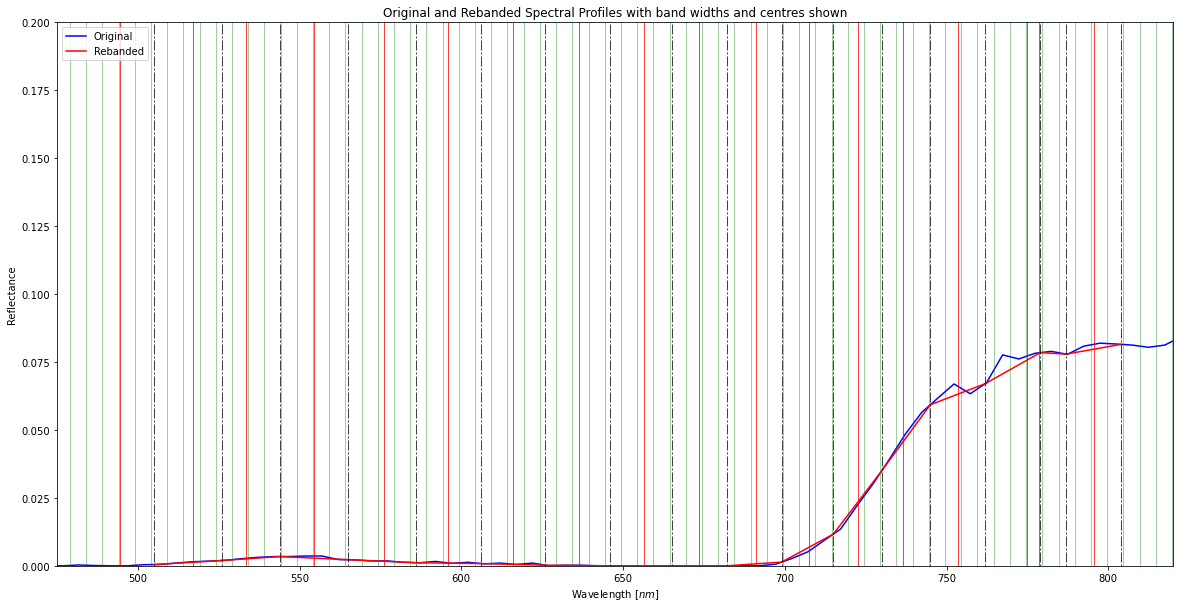

In [50]:
i, j = 100, 100
fig, ax = plt.subplots(figsize=(20, 10))
# plot some random wavelengths
temp_spec = reband_spectral_array(refl_array[i,j,:], wavelength_array, desired_band_centres)
temp_bandwidths = band_widths(desired_band_centres)

# original
ax.plot(wavelength_array, refl_array[100,100,:], c='b', label="Original")
ax.plot([wavelength_array-FWHM_array/2,wavelength_array-FWHM_array/2], [0,1], c='g', alpha=0.75, linewidth=0.5) # band widths

ax.plot(desired_band_centres, temp_spec, c='r', label="Rebanded")
ax.plot([desired_band_centres-temp_bandwidths/2,desired_band_centres-temp_bandwidths/2], [0,1], c='r', alpha=0.75, linewidth=1) # band widths
ax.plot([desired_band_centres,desired_band_centres], [0,1], c='k', dashes=[2, 2, 10, 2], alpha=0.75, linewidth=1) # band centre


#ax.plot([desired_band_centres,desired_band_centres], [0,1], c='k', dashes=[2, 2, 10, 2], alpha=0.5, label='Using the dashes parameter') # band centres # 2pt line, 2pt break, 10pt line, 2pt break
#ax.plot([desired_band_centres,desired_band_centres], [0,1], c='k', dashes=[2, 2, 10, 2], alpha=0.5, label='Using the dashes parameter') # band widths
plt.title("Original and Rebanded Spectral Profiles with band widths and centres shown")
plt.ylabel('Reflectance')
plt.ylim((0,0.2))
plt.xlim((475,820))
plt.xlabel('Wavelength [$nm$]')
plt.legend()
plt.show()

In [34]:
# create another set of bands to reband original to
desired_band_centres_2 = np.array(range(505,2000,10))
desired_band_centres_2

array([ 505,  515,  525,  535,  545,  555,  565,  575,  585,  595,  605,
        615,  625,  635,  645,  655,  665,  675,  685,  695,  705,  715,
        725,  735,  745,  755,  765,  775,  785,  795,  805,  815,  825,
        835,  845,  855,  865,  875,  885,  895,  905,  915,  925,  935,
        945,  955,  965,  975,  985,  995, 1005, 1015, 1025, 1035, 1045,
       1055, 1065, 1075, 1085, 1095, 1105, 1115, 1125, 1135, 1145, 1155,
       1165, 1175, 1185, 1195, 1205, 1215, 1225, 1235, 1245, 1255, 1265,
       1275, 1285, 1295, 1305, 1315, 1325, 1335, 1345, 1355, 1365, 1375,
       1385, 1395, 1405, 1415, 1425, 1435, 1445, 1455, 1465, 1475, 1485,
       1495, 1505, 1515, 1525, 1535, 1545, 1555, 1565, 1575, 1585, 1595,
       1605, 1615, 1625, 1635, 1645, 1655, 1665, 1675, 1685, 1695, 1705,
       1715, 1725, 1735, 1745, 1755, 1765, 1775, 1785, 1795, 1805, 1815,
       1825, 1835, 1845, 1855, 1865, 1875, 1885, 1895, 1905, 1915, 1925,
       1935, 1945, 1955, 1965, 1975, 1985, 1995])

In [35]:
print("Orginal number of bands: ",len(wavelength_array))

Orginal number of bands:  426


In [36]:
print("Expected number of bands: ",(2000-505)/10)

Expected number of bands:  149.5


In [37]:
new_spectrum_2 = reband_spectral_array(refl_array[100,100,:], wavelength_array, desired_band_centres_2)
print("Actual number of bands: ",len(new_spectrum_2))

Actual number of bands:  150


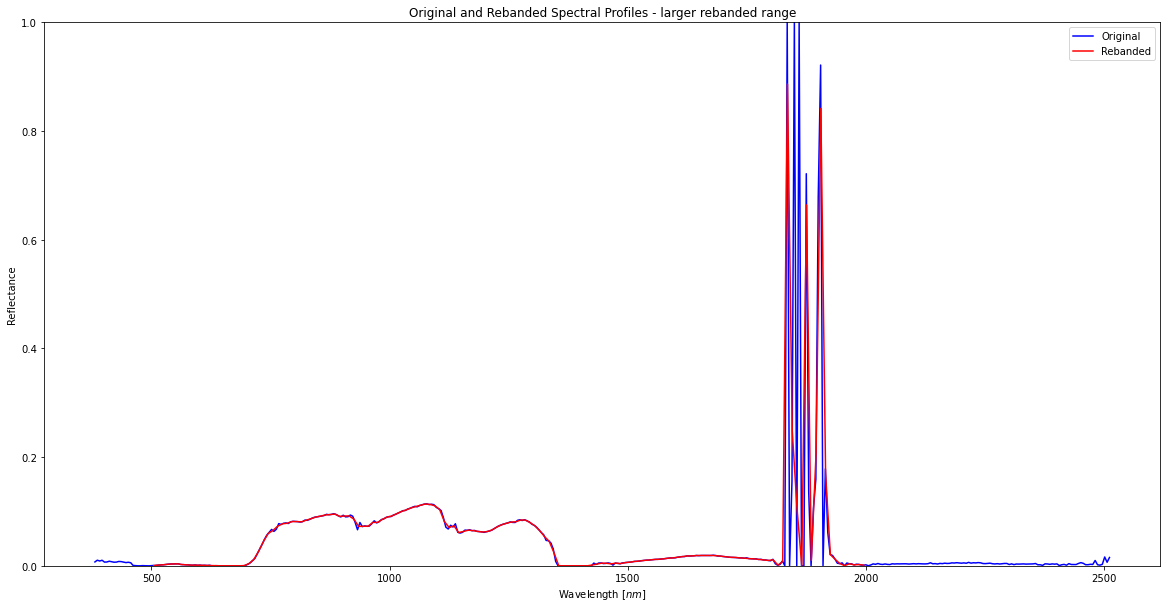

In [57]:
i, j = 10, 10
fig, ax = plt.subplots(figsize=(20, 10))
# plot some random wavelengths
new_spectrum_2 = reband_spectral_array(refl_array[100,100,:], wavelength_array, desired_band_centres_2)

ax.plot(wavelength_array, refl_array[100,100,:], c='b', label="Original")
ax.plot(desired_band_centres_2, new_spectrum_2, c='r', label="Rebanded")
#ax.plot([desired_band_centres,desired_band_centres_2], [0,1], c='g')
#ax.set_xticks(range(0, 250, 3000))
plt.title("Original and Rebanded Spectral Profiles - larger rebanded range")
plt.ylabel('Reflectance')
plt.ylim((0,1))
#plt.xlim((0,1000))
plt.xlabel('Wavelength [$nm$]')
plt.legend()
plt.show()

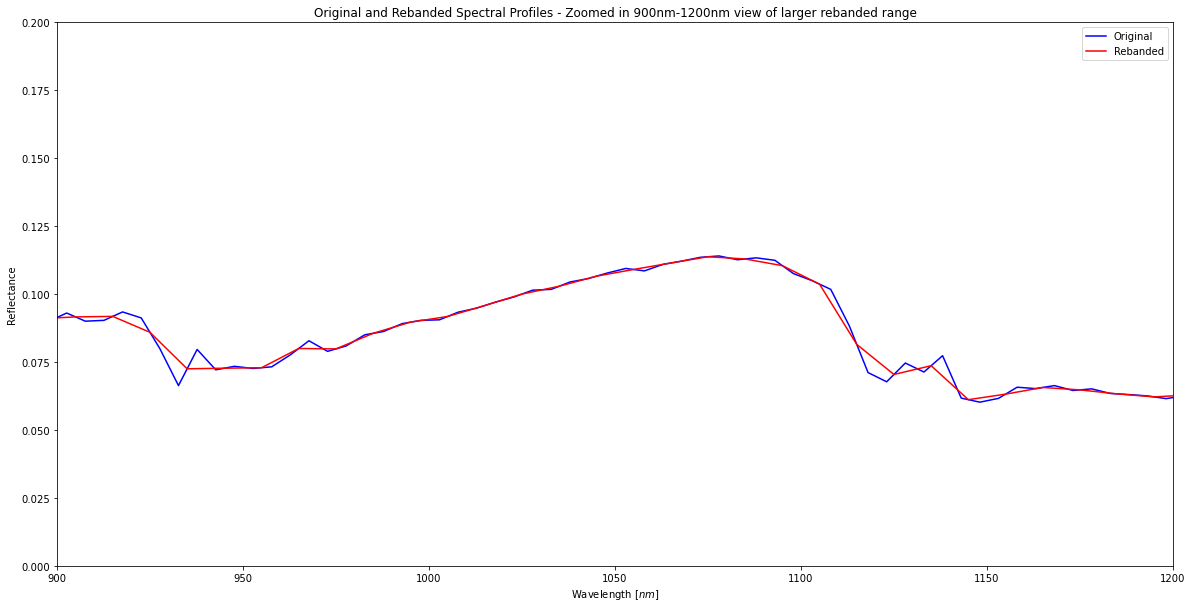

In [58]:
i, j = 10, 10
fig, ax = plt.subplots(figsize=(20, 10))
# plot some random wavelengths
new_spectrum_2 = reband_spectral_array(refl_array[100,100,:], wavelength_array, desired_band_centres_2)

ax.plot(wavelength_array, refl_array[100,100,:], c='b', label="Original")
ax.plot(desired_band_centres_2, new_spectrum_2, c='r', label="Rebanded")
#ax.plot([desired_band_centres_2,desired_band_centres_2], [0,1], c='g')
#ax.set_xticks(range(0, 250, 3000))
plt.title("Original and Rebanded Spectral Profiles - Zoomed in 900nm-1200nm view of larger rebanded range")
plt.ylabel('Reflectance')
plt.ylim((0,0.2))
plt.xlim((900,1200))
plt.xlabel('Wavelength [$nm$]')
plt.legend()
plt.show()

In [40]:
# i, j = 100, 100
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
# # plot random wavelength (pixel i,j)
# new_spectrum_2 = reband_spectral_array(refl_array[i,j,:], wavelength_array, desired_band_centres)
# temp_bandwidths = band_widths(desired_band_centres)

# # original spectrum
# ax[0].plot(wavelength_array, refl_array[i,j,:], c='b', label="Original")
# ax[0].plot([wavelength_array-FWHM_array/2,wavelength_array-FWHM_array/2], [0,1], c='g', alpha=0.75, linewidth=0.5) # band widths

# # rebanded spectrum
# #ax[0].plot(wavelength_array, refl_array[i,j,:], c='b', label="Original")
# ax[1].plot(desired_band_centres, new_spectrum_2, c='r', label="Rebanded")
# ax[1].plot([desired_band_centres-temp_bandwidths/2,desired_band_centres-temp_bandwidths/2], [0,1], c='g', alpha=0.75, linewidth=0.5) # band widths
# #ax[1].plot([desired_band_centres,desired_band_centres], [0,1], c='k', dashes=[2, 2, 10, 2], alpha=0.75, linewidth=0.5) # band centres # 2pt line, 2pt break, 10pt line, 2pt break

# ax[0].set_title("Original Spectral Profile with Bands Shown")
# ax[0].set_title("Original Spectral Profile with Bands Shown")

# for ax in ax:
#     ax.set_ylim((0,0.2))
#     ax.set_xlim((375,1000))
#     ax.set_ylabel('Reflectance')
#     ax.set_xlabel('Wavelength [$nm$]')

# plt.legend()
# plt.show()

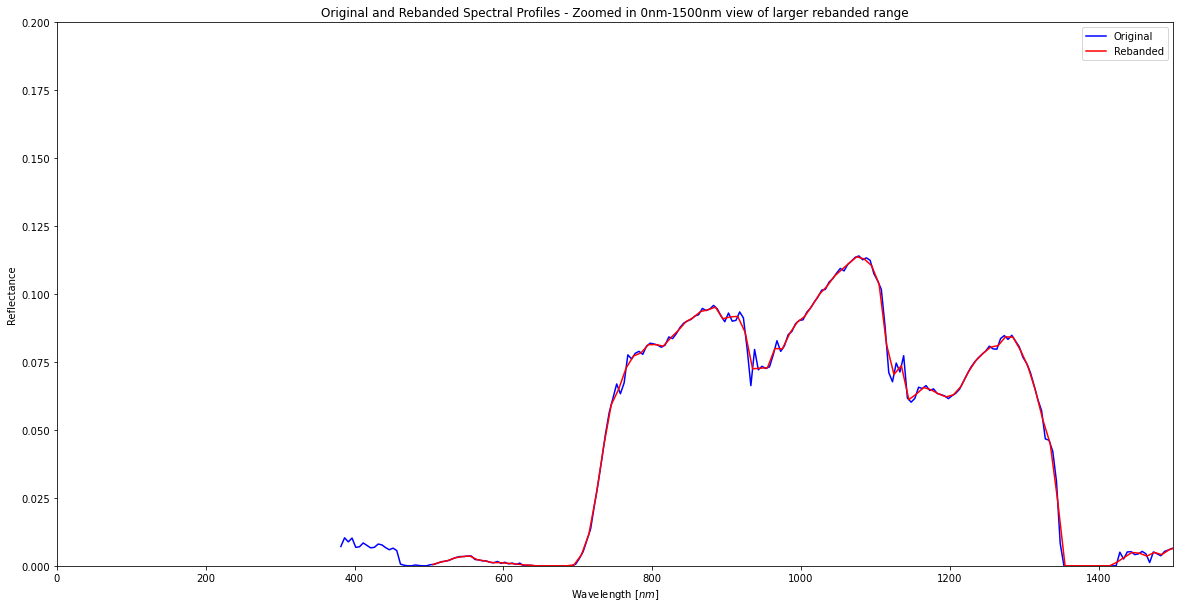

In [59]:
i, j = 10, 10
fig, ax = plt.subplots(figsize=(20, 10))
# plot some random wavelengths
new_spectrum_2 = reband_spectral_array(refl_array[100,100,:], wavelength_array, desired_band_centres_2)

ax.plot(wavelength_array, refl_array[100,100,:], c='b', label="Original")
ax.plot(desired_band_centres_2, new_spectrum_2, c='r', label="Rebanded")
#ax.plot([desired_band_centres_2,desired_band_centres_2], [0,1], c='g')
#ax.set_xticks(range(0, 250, 3000))
plt.title("Original and Rebanded Spectral Profiles - Zoomed in 0nm-1500nm view of larger rebanded range")
plt.ylabel('Reflectance')
plt.ylim((0,0.2))
plt.xlim((0,1500))
plt.xlabel('Wavelength [$nm$]')
plt.legend()
plt.show()

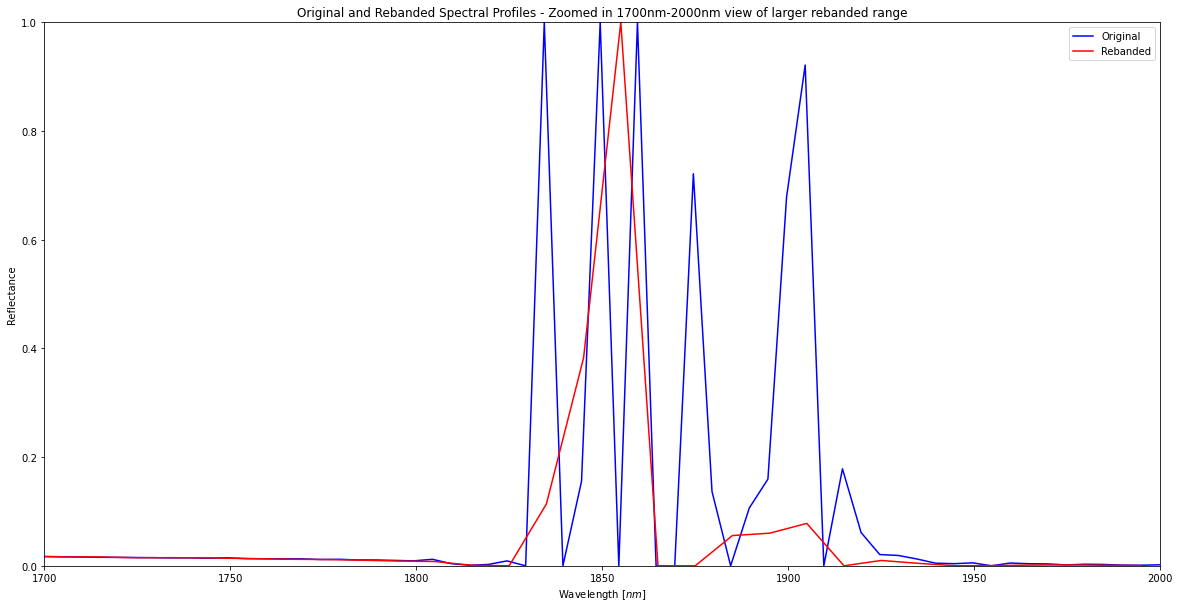

In [61]:
i, j = 10, 10
fig, ax = plt.subplots(figsize=(20, 10))
# plot some random wavelengths
new_spectrum_2 = reband_spectral_array(refl_array[100,0,:], wavelength_array, desired_band_centres_2)

ax.plot(wavelength_array, refl_array[100,100,:], c='b', label="Original")
ax.plot(desired_band_centres_2, new_spectrum_2, c='r', label="Rebanded")
#ax.plot([desired_band_centres_2,desired_band_centres_2], [0,1], c='g')
#ax.set_xticks(range(0, 250, 3000))
plt.title("Original and Rebanded Spectral Profiles - Zoomed in 1700nm-2000nm view of larger rebanded range")
plt.ylabel('Reflectance')
plt.ylim((0,1))
plt.xlim((1700,2000))
plt.xlabel('Wavelength [$nm$]')
plt.legend()
plt.show()

## Technical Note on Spatial and Spectral Down-sampling

Some further details and discussion of the process and the advantages as well as limitations of this approach is warrented.
The process of downsampling involves the following steps:
1. Calculate a downsampling factor 
2. Use the downsampling factor to determine a block of pixels to aggregate
3. Aggregate the pixels into a single (spatial) pixel value (repeated across the entire spectral Z axis as well)
4. Linearly interpolate the reflectance values to spectrally downsample
5. Re-size the image back up to original image dimensions


1. __Downsampling:__ The process for downsampling spatially involves calculating a scale factor based on the original image's Ground Sample Distance (GSD) and the desired output GSD. The scale factor is simply the ratio between the two: output GSD / input GSD. Due to how the block downsampling function works and for simplicity the scale factor is also rounded to the nearest integer value. The down-scaling factor is also capped on the lower end to 1 (no up-scaling supported!). This scale factor dictates how many pixels will be aggregated in the next downsampling block aggregation step.

2. __Block Aggregation:__ Once we have the downsampling scale factor we will utilize scikit-image's block_reduce function with the mean function used for the aggregating. The mean averaging agreggation function was used over other approaches like picking the max value pixel or a centre pixel as it preserves more information in the output. The following image may provide a clearer idea of how the block function is working on the original input pixels to generate an output pixel:

With a down-scaling factor _S_, and input pixel values _P_:

 _Output Pixel Value_ $ = \frac{1}{S^2} \sum \limits _{i,j=1} ^{S}  P_{ij} $

![title](img/TechnicalNoteDiagram_crop.png)


3. __Apply Aggregation:__ The input image is divided into these blocks along the x and y axis and aggregated output pixels generated to form a new image. This blocking and aggregation strategy is propogated in layers though the z-axis. i.e. each layer of pixels in the z-axis is spatially downsampled along the x and y-axis (it is helpful to think of hyperspectral image data as a 3-D cube of pixels where the x and y-axis are the spatial dimensions and the z-axis is the spectral dimension of various wavelengths).

4. __Spectral Resampling:__ The spectral resampling step is applied next - the benefit of doing this step after the spatial downsampling but before the image rescale step is that there is a reduced set of pixels for the operation to process (scaling factor S less total pixels) hence saving a great deal of computation time. A linear interpolation algorithm is used to resample the spectral dimension along the z-axis for each pixel Pij in the x and y dimension. The linear interpolation algorithm takes in three arrays: the input image's measured reflectance values, the corresponding input image's band centre wavelengths for those measured values, and the desired output new band centre wavelengths. The input centre wavelength and reflectance values form the x and y data used in a step-wise interpolation from which a "new" y reflectance value is interpolated at the desired x output band centres. This can be seen in action in the previous graphs showing the original and rebanded spectral plots.

5. In order to preserve image size to output the same sized image as was input, the image needs to be scaled back up to 1000 x 1000 pixels from the e.g. 500 x 500 downsampled pixels. This is done with scikit-image's rescale functionality which scales the image back up (interpolating the missing pixels in the process).

---
__Notes on Process:__
The net effect of these transformations is similar to applying a smoothing function across the pixels and then a sort of low-pass filter effect along the spectral z axis leading to a loss in image detail and fidelity along all axises. This loss of information is desired in the case where we are trying to simulate the output of a satellite-based instrument imaging from a much greater distance vs. an airbourne platform-based instrument.

__Advantages:__ The described process has the advantage of being straightforward and computationally fast and efficient, while giving us the flexibility to determine many of the desired parameters and charateristics of the output imagery.

__Limitations:__ While being performant the interpolation struggles in regions of the spectrum that have a rapid variation of extreme reflectance values - though further work is required to determine the nature of these extreme values (many of which exceed a maximum reflectance value of 1). We also decide the magnitude of the reflectance value of these new bands with a linear interpolation - not neccessarily the best way to decide if a photon would have fallen into a particular band "bucket". This method doesn't really account for possibilty of overlapping bands or gaps between bands and is simply generating a reflectance value for a new band centre based on the already measured reflectances of nearby bands of data that the interpolation is being based off of.

Additionally we are essentially re-interpreting an already existing image (set of reflectance bands) into a new set of reflectance bands and hence will be subject to all of the limitations of the AVARIS-NG instrument and the processing steps performed by NEON on their imagery we use as our input to this process. 

## 5. Combined Spatial and Spectral Resampling function
Combining both the spatial downsampling functionality and the spectral rebanding functionality
Order of operations:
- input array of data that is passed in goes through spatial resampling - downsampled by scaling factor using averaging method
- on downsampled array the spectral rebanding 

Note: The function uses a linear interpolation method in the resampling.

In [23]:
def downSample_reband_array(img_array, GSD_input, GSD_output, input_bandcentres_array, output_bandcentres_array):
    """
    Returns a spatially downsampled (x,y dim) 3-D hyperspectral image array 
    which has also has its spectral dimension (z) rebanded to a desired set of band centres.
    
    Parameters
    -----------
    img_array : 3-D array_like
                Array of image reflectance data - [x,y] dimensions are spatial and [z] dimension is the spectral component.
    
    GSD_input : integer or float
                The Ground Sample Distance (GSD) of the input image in meters.
                If a float is provided the actual scaling factor will be an integer of the rounded ratio of GSD_output/GSD_input.
                
    GSD_output : integer or float
                The desired Ground Sample Distance (GSD) of the ouput image in meters.
                If a float is provided the actual scaling factor will be an integer of the rounded ratio of GSD_output/GSD_input.
    
    input_bandcentres_array : array_like
                The spectral band centres of the input image array.
            
    output_bandcentres_array : array_like
                The desired spectral band centres of the output image array.
    
    
    Returns
    -------
    image : ndarray
        Down-sampled image with the same [x,y] dimensions and a rebanded [z] dimension
    
    
    Example Execution:
    --------
    img_array_ds = downSample_array(img_array, 1, 2) # downsample image by factor of 2
    
    """
    
    downsample_factor = max(int(round(GSD_output/GSD_input)),1) # calculate the downsampling factor - only integers!
    rescale_factor = float(downsample_factor)
    img_array_ds = skimage.measure.block_reduce(img_array[:, :, :], 
                                             block_size=(downsample_factor, downsample_factor, 1), 
                                             func=np.mean) # downsample image array
    
    # create empty array to store the rebanded spectral arrays
    rebanded_array = np.empty((img_array_ds.shape[0], img_array_ds.shape[1], len(output_bandcentres_array)))  
    
    # loop through all spatial pixels and reband the spectral component of each one
    for x in range(0,img_array_ds.shape[0]): # x dimension
        for y in range(0,img_array_ds.shape[1]): # y dimension
            
            rebanded_array[x, y, :] = reband_spectral_array(img_array_ds[x, y, :], 
                                                            input_bandcentres_array, 
                                                            output_bandcentres_array) # build up empty array with rebanded arrays
    
    # upscale image back to original input image size (interpolating pixels in between)
    return skimage.transform.rescale(rebanded_array,(rescale_factor,rescale_factor,1.0)) # scale back up to original size (interpolates)



Lets test out our combined spatial and spectral down/resampling function.
We'll use our previous set of input band centres and a GSD output of 4 m.

In [24]:
print("First 50 original input band centres")
print(wavelength_array[:50])
print("-"*75)
print("Desired output band centres")
print(desired_band_centres)

First 50 original input band centres
[381.598  386.6077 391.6175 396.6273 401.637  406.6468 411.6566 416.6663
 421.6761 426.6858 431.6956 436.7054 441.7151 446.7249 451.7347 456.7444
 461.7542 466.764  471.7737 476.7835 481.7933 486.803  491.8128 496.8226
 501.8323 506.8421 511.8519 516.8616 521.8714 526.8812 531.8909 536.9007
 541.9105 546.9202 551.93   556.9398 561.9495 566.9593 571.9691 576.9788
 581.9886 586.9984 592.0081 597.0179 602.0277 607.0374 612.0472 617.057
 622.0667 627.0765]
---------------------------------------------------------------------------
Desired output band centres
[505. 526. 544. 565. 586. 606. 626. 646. 665. 682. 699. 715. 730. 745.
 762. 779. 787. 804.]


In [32]:
resamp_refl_array = downSample_reband_array(refl_array, 1, 5, wavelength_array, desired_band_centres)

In [33]:
refl_array.shape # original hyperspectral data array

(1000, 1000, 426)

In [34]:
resamp_refl_array.shape

(1000, 1000, 18)

In [35]:
# testing & error checking

def array_stats(input_array):
    print("Mean reflectance: "'{number:.{digits}f}'.format(number=input_array.mean(), digits=3))
    print("Std Dev.: "'{number:.{digits}f}'.format(number=input_array.std(), digits=3))
    print("Min reflectance: "'{number:.{digits}f}'.format(number=input_array.min(), digits=3))
    print("Max reflectance: "'{number:.{digits}f}'.format(number=input_array.max(), digits=3))
    print("-"*35)
    
array_stats(refl_array[:,:,0])
array_stats(refl_array[:,:,6])
array_stats(refl_array[:,:,13])
print('-'*50)
print(refl_array[0,0:20,0])
print('-'*50)
print(refl_array[0,0:20,6])
print('-'*50)
print(refl_array[0,0:20,13])

Mean reflectance: 0.015
Std Dev.: 0.007
Min reflectance: 0.000
Max reflectance: 0.135
-----------------------------------
Mean reflectance: 0.020
Std Dev.: 0.011
Min reflectance: 0.000
Max reflectance: 0.453
-----------------------------------
Mean reflectance: 0.020
Std Dev.: 0.013
Min reflectance: 0.002
Max reflectance: 0.571
-----------------------------------
--------------------------------------------------
[0.0092 0.0108 0.0103 0.008  0.0087 0.0107 0.0092 0.008  0.0081 0.007
 0.0095 0.0076 0.0032 0.009  0.0097 0.0096 0.0158 0.0145 0.02   0.016 ]
--------------------------------------------------
[0.0123 0.0111 0.0122 0.0097 0.0107 0.0085 0.0086 0.0088 0.0098 0.0096
 0.0089 0.0085 0.0085 0.0091 0.0091 0.0101 0.02   0.0236 0.0236 0.0235]
--------------------------------------------------
[0.0096 0.0096 0.013  0.0075 0.0095 0.0078 0.0067 0.0071 0.0061 0.007
 0.0071 0.0062 0.0055 0.0074 0.0081 0.0094 0.0198 0.0239 0.0256 0.0234]


In [36]:
# testing & error checking

def array_stats(input_array):
    print("Mean reflectance: "'{number:.{digits}f}'.format(number=input_array.mean(), digits=3))
    print("Std Dev.: "'{number:.{digits}f}'.format(number=input_array.std(), digits=3))
    print("Min reflectance: "'{number:.{digits}f}'.format(number=input_array.min(), digits=3))
    print("Max reflectance: "'{number:.{digits}f}'.format(number=input_array.max(), digits=3))
    print("-"*35)
    
array_stats(resamp_refl_array[:,:,0])
array_stats(resamp_refl_array[:,:,6])
array_stats(resamp_refl_array[:,:,13])
print('-'*50)
print(resamp_refl_array[0,0:20,0])
print('-'*50)
print(resamp_refl_array[0,0:20,6])
print('-'*50)
print(resamp_refl_array[0,0:20,13])

Mean reflectance: 0.014
Std Dev.: 0.011
Min reflectance: 0.000
Max reflectance: 0.312
-----------------------------------
Mean reflectance: 0.022
Std Dev.: 0.017
Min reflectance: 0.000
Max reflectance: 0.340
-----------------------------------
Mean reflectance: 0.245
Std Dev.: 0.073
Min reflectance: 0.018
Max reflectance: 0.617
-----------------------------------
--------------------------------------------------
[0.00971089 0.01087442 0.01203796 0.01087442 0.00971089 0.00854735
 0.00738381 0.00622027 0.00558471 0.00494915 0.00431359 0.00367803
 0.00304247 0.00483421 0.00662594 0.00841768 0.01020941 0.01200114
 0.01272541 0.01344969]
--------------------------------------------------
[0.01471589 0.01640226 0.01808863 0.01640226 0.01471589 0.01302952
 0.01134315 0.00965678 0.00856528 0.00747378 0.00638228 0.00529078
 0.00419929 0.00702895 0.00985862 0.01268828 0.01551795 0.01834761
 0.0194285  0.02050939]
--------------------------------------------------
[0.16078927 0.17032933 0.179869

#### Lets see what the spectral profile of some random pixels looks like:

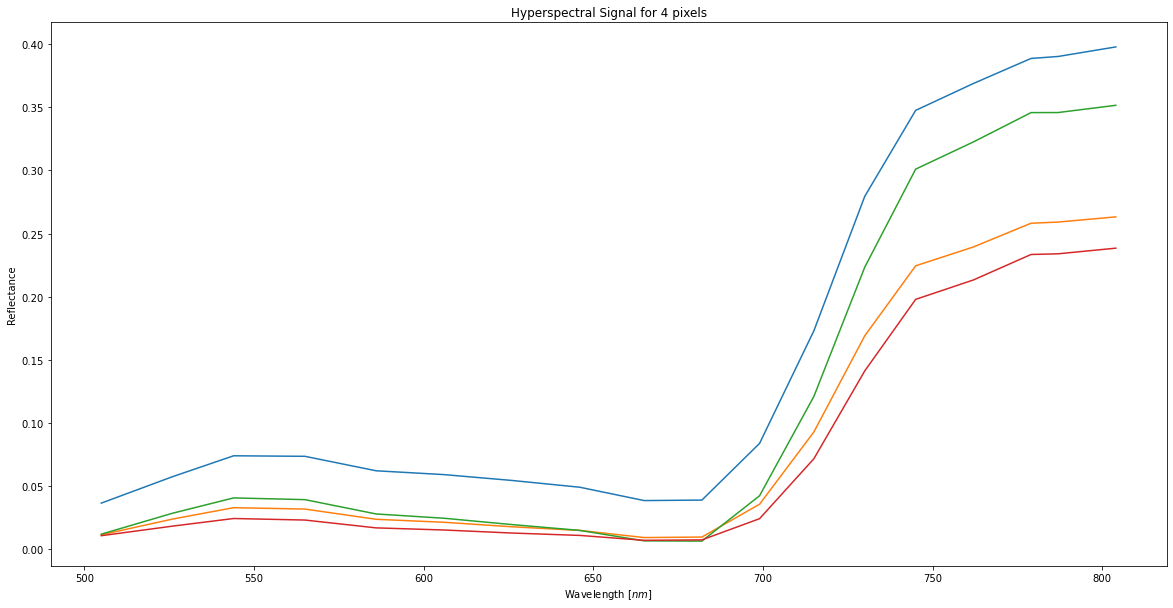

In [31]:
i, j = 10, 10
fig, ax = plt.subplots(figsize=(20, 10))
# plot some random wavelengths

#ax.plot(wavelength_array, refl_array[100,100,:], c='b', marker="1")
ax.plot(desired_band_centres, resamp_refl_array[i+50,j,:])
ax.plot(desired_band_centres, resamp_refl_array[i,j+50,:])
ax.plot(desired_band_centres, resamp_refl_array[i+800,j+800,:])
ax.plot(desired_band_centres, resamp_refl_array[i+900,j+900,:])

#ax.plot([desired_band_centres,desired_band_centres], [0,1], c='g') # CHANGE to band widths (not centres)
plt.title("Hyperspectral Signal for 4 pixels")
plt.ylabel('Reflectance')
#plt.ylim((0,0.2))
#plt.xlim((0,1000))
plt.xlabel('Wavelength [$nm$]')
plt.show()

## 6. Write out down-sampled datacube to HDF5 file

In [23]:
def array2h5data(refl_array, wavelength_array, FWHM_array, metadata_dict, filename_output):
    """
    Takes in a 3-D reflectance array, an array of band centre wavelengths, FWHM array, 
    and an additional metadata dictionary and generates a HDF5 file with the given filename.
    """

    # scale the reflectance data up by the original reflectance factor to save disk space
    scale_fac = metadata_dict['reflectance scale factor']
    refl_array = refl_array*scale_fac
    
    hf = h5py.File(filename_output, 'w') # create hdf5 file
    g1 = hf.create_group('Reflectance') # create main group
    g2 = hf.create_group('Reflectance/Metadata') # group for metadata
    
    # datasets
    # ------------------------------------------------------------------------------
    # reflectance data
    refl_dset = g1.create_dataset('Reflectance_Data',data=refl_array, dtype='i') # dataset for reflectance data
    refl_dset.attrs['Description'] = 'Atmospherically corrected reflectance.'
    refl_dset.attrs['data ignore value'] = metadata_dict['data ignore value']
    refl_dset.attrs['reflectance scale factor'] = metadata_dict['reflectance scale factor']
    refl_dset.attrs['Spatial_Resolution_X_Y'] = metadata_dict['Spatial_Resolution_X_Y']
    refl_dset.attrs['spatial extent'] = metadata_dict['spatial extent']
    
    # wavelength data
    wav_dset = g2.create_dataset('Wavelength',data=wavelength_array) # band centre wavelength data
    wav_dset.attrs['Description'] = 'Central wavelength of the reflectance bands.'
    wav_dset.attrs['Units'] = 'nanometers'
    
    # FWHM data
    FWHM_dset = g2.create_dataset('FWHM',data=FWHM_array) # FWHM data
    FWHM_dset.attrs['Description'] = 'Full width half maximum of reflectance bands.'
    FWHM_dset.attrs['Units'] = 'nanometers'
    
    
    hf.close() # close file to save and write to disk

- lets test out our HDF5 file writing function

In [86]:
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'interim' / 'hdf5_downsampled' / 'NEON_D16_ABBY_DP3_552000_5071000_reflectance_downsampled.h5' # output path to save hdf5 data cube
array2h5data(refl_array, wavelength_array, FWHM_array, metadata_dict, output_data_path)

In [87]:
#fpath = r"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\interim\hdf5_downsampled"
#h5dump(os.path.normpath(fpath))
fpath = r"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\interim\hdf5_downsampled\NEON_D16_ABBY_DP3_552000_5071000_reflectance_original.h5"
h5dump(os.path.normpath(fpath))

	 - Reflectance : <HDF5 group "/Reflectance" (2 members)>
		 - Metadata : <HDF5 group "/Reflectance/Metadata" (2 members)>
			 - FWHM : <HDF5 dataset "FWHM": shape (426,), type "<f4">
					 - Description : Full width half maximum of reflectance bands.
					 - Units : nanometers
			 - Wavelength : <HDF5 dataset "Wavelength": shape (426,), type "<f4">
					 - Description : Central wavelength of the reflectance bands.
					 - Units : nanometers
		 - Reflectance_Data : <HDF5 dataset "Reflectance_Data": shape (1000, 1000, 426), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [1. 1.]
				 - data ignore value : -9999.0
				 - reflectance scale factor : 10000.0
				 - spatial extent : [ 552000.  553000. 5071000. 5072000.]


- It works, yay!

In [30]:
file_dict['NEON_D16_WREF_DP3_579000_5081000_reflectance.h5']

'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D16.WREF.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_WREF_DP3_579000_5081000_reflectance.h5'

## 7. Entire Sample (Mini) Data Downsampling Pipeline

Roll all the functionalities we've developed together into a mini data down-sampling pipeline! 
- Read in NEON HDF5 images sequentially
- Downsample image data cube; both spatially and spectrally
- Generate a sample image from the dwonsampled data cube
- Finally write out downsampled hdf5 file

In [ ]:
## set up our desired bands and GSD parameters, as well as our input and output files directory
# 0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646,  0.665, 0.682, 0.699, 0.715, 0.730, 0.745, 0.762, 0.779, 0.787, 0.804
desired_band_centres = np.array([0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646, 0.665, 0.682, 0.699, 0.715, 0.730, 0.745, 0.762, 0.779, 0.787, 0.804])
desired_band_centres = desired_band_centres*1000
desired_GSD = 4 # 4m GSD
data_dir_path = Path(os.getcwd()).parents[0] / 'data' / 'NEON' # get path to data files
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'interim' # output data directory
print("Parameters set...")

# get all input HDF5 files
file_dict = find_files(data_dir_path)
print("Input files found...")

for file_name, file_path in file_dict.items():
    print("Processing file: ",file_name)
    # read the h5data2array for an image
    #file_name = 'NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5'
    data_file_path = file_dict[file_name]
    refl_array, wavelength_array, FWHM_array, metadata_dict = h5data2array(data_file_path)
    print("File loaded...")

    # perform downsampling
    resamp_refl_array = downSample_reband_array(refl_array, metadata_dict['Spatial_Resolution_X_Y'][0], desired_GSD, wavelength_array, desired_band_centres) # downsample
    metadata_dict['Spatial_Resolution_X_Y'] = [float(desired_GSD), float(desired_GSD)] # adjust resolution metadata to reflect downsampling
    print("Downsampling Complete...")

    # generate image
    output_img_name = file_name.replace('.h5', '') + '_img_' + str(desired_GSD) + 'mGSD.png' # remove .h5 ending and replace with img, GSD and .png
    output_data_path_filename = Path(output_data_path / 'img' / output_img_name) # output path to save processed data files
    toRGB(resamp_refl_array, output_data_path_filename, mode=2) # generate and save image
    print("Image Generated...")

    # write out file
    output_hdf5_name = file_name.replace('.h5', '') + '_downsampled_' + str(desired_GSD) + 'mGSD.h5' # add downsampled, GSD and .h5 file ending
    output_data_path_filename = Path(output_data_path / 'hdf5_downsampled' / output_hdf5_name) # output path to save processed data files
    band_width_array = band_widths(desired_band_centres)
    array2h5data(resamp_refl_array, desired_band_centres, band_width_array, metadata_dict, output_data_path_filename) # save hdf5 data cube
    print("HDF5 File Written to Disk...")

print("Processing Complete!")

## WIP CODE BELOW CLEAN/DELETE LATER -----------------------------------

In [ ]:
# serc_plot = plt.imshow(b56,extent=serc_ext,cmap='Greys',clim=(0,0.4)) 
# plt.title('SERC Band 56 Reflectance');